In [2]:
# Importar librerías
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')

In [3]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [212]:
# Importar datos
path = '/content/drive/MyDrive/Coding Dojo/Modulo 2/ds_salaries.csv'
df = pd.read_csv(path)
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [214]:
# Cantidad de filas y columnas
df.shape

(3755, 11)

In [215]:
# Buscar filas duplicadas
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
3750    False
3751    False
3752    False
3753    False
3754    False
Length: 3755, dtype: bool

In [216]:
# Contar valores duplicados
df.duplicated().sum()

1171

Debido a que no hay una columna con un identificador(código), ni se cuenta con variables que permitan construir un identificador único para cada registro, se decide no eliminar las filas que aparecen como duplicadas, ya que podría subestimarse el modelo y restar robustez a los resultados.

In [217]:
# Eliminar duplicados
#df = df.drop_duplicates()
#df.duplicated().sum()

In [218]:
# Identificar valores faltantes(nulos) por columna
df.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [219]:
# Total de valores faltantes
print(df.isna().sum().sum(), 'missing values')

0 missing values


In [220]:
df['experience_level'].value_counts()

SE    2516
MI     805
EN     320
EX     114
Name: experience_level, dtype: int64

EN = Entry Level

MI = Mid Level

SE = Senior Level

EX = Executive Level.

In [221]:
df['company_size'].value_counts()

M    3153
L     454
S     148
Name: company_size, dtype: int64

In [222]:
df['job_title'].value_counts()

Data Engineer                          1040
Data Scientist                          840
Data Analyst                            612
Machine Learning Engineer               289
Analytics Engineer                      103
                                       ... 
Principal Machine Learning Engineer       1
Azure Data Engineer                       1
Manager Data Management                   1
Marketing Data Engineer                   1
Finance Data Analyst                      1
Name: job_title, Length: 93, dtype: int64

In [223]:
# En la columna 'experience_level' se puede clasificar los datos de manera ordinal
df['experience_level'] = df['experience_level'].replace('EN', 0)
df['experience_level'] = df['experience_level'].replace('MI', 1)
df['experience_level'] = df['experience_level'].replace('SE', 2)
df['experience_level'] = df['experience_level'].replace('EX', 3)
df['experience_level'].value_counts()

2    2516
1     805
0     320
3     114
Name: experience_level, dtype: int64

In [224]:
# La columna 'company_size' se puede clasificar manera ordinal
df['company_size'] = df['company_size'].replace('S', 0)
df['company_size'] = df['company_size'].replace('M', 1)
df['company_size'] = df['company_size'].replace('L', 2)
df['company_size'].value_counts()

1    3153
2     454
0     148
Name: company_size, dtype: int64

In [225]:
# Obtener las estadísticas de las columnas numéricas
df.describe().round(2)

,work_year,experience_level,salary,salary_in_usd,remote_ratio,company_size
count,3755.00,3755.00,3755.00,3755.00,3755.00,3755.00
mean,2022.37,1.65,190695.57,137570.39,46.27,1.08
std,0.69,0.68,671676.50,63055.63,48.59,0.39
min,2020.00,0.00,6000.00,5132.00,0.00,0.00
25%,2022.00,1.00,100000.00,95000.00,0.00,1.00
50%,2022.00,2.00,138000.00,135000.00,0.00,1.00
75%,2023.00,2.00,180000.00,175000.00,100.00,1.00
max,2023.00,3.00,30400000.00,450000.00,100.00,2.00


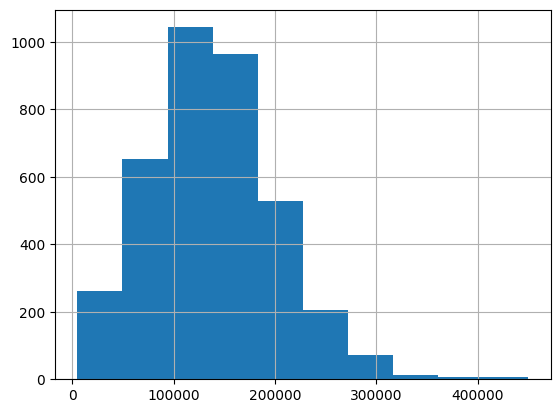

In [226]:
# Hacer un histograma y remover notación científica
df['salary_in_usd'].hist()
plt.ticklabel_format(useOffset=False, style='plain')

Podemos ver que la la mayor concentración de observaciones, se concentran en el rango de salario 100000 a 200000.

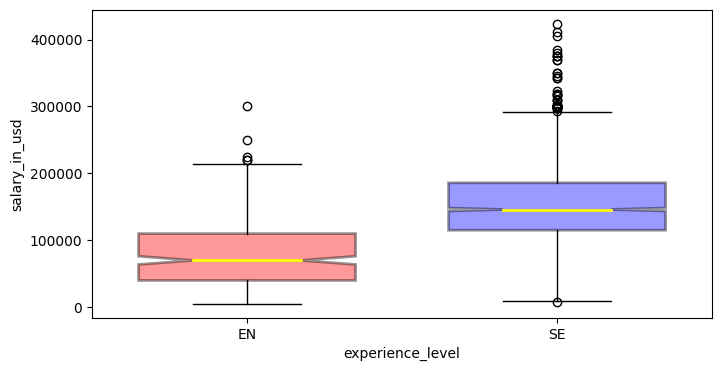

In [227]:
# Para analizar mejor los salarios, se genera un gráfico agregando una variable categórica
# Se genera estilo seaborn
# Se generan dos df, uno para cada filtro creado
# Se genera el boxplot
entry_level = df.loc[df['experience_level']==0,'salary_in_usd']
senior_level = df.loc[df['experience_level']==2,'salary_in_usd']
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (8,4))
boxplots = axes.boxplot([entry_level,senior_level],
           notch = True,
           labels=['EN', 'SE'],
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );
# Se personaliza el gráfico
boxplot1 = boxplots['boxes'][0]
boxplot1.set_facecolor('red')
plt.xlabel('experience_level', fontsize = 10);
plt.ylabel('salary_in_usd', fontsize = 10);
plt.xticks(fontsize = 10);
plt.yticks(fontsize = 10);

Se puede observar que las distribuciones de los datos(salary_in_usd) son un poco diferentes cuando el nivel de experiencia es el más bajo y cuando es "senior". Además en ambos casos existen algunos valores atípicos que se encuentran por encima del "máximo", especialmente en el nivel de experiencia "senior".

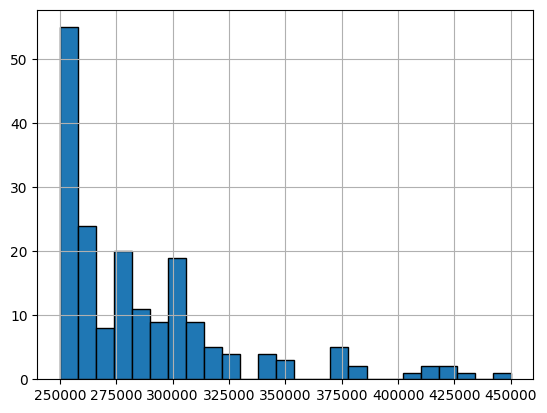

In [290]:
# Visualizar el subgrupo de datos de salario >= a 25000 USD
salary_filter = df.loc[:, 'salary_in_usd'] >= 250000
df.loc[salary_filter, 'salary_in_usd'].hist(bins = 25,
                                   edgecolor='black')
plt.ticklabel_format(useOffset=False, style='plain')

Dentro de este grupo existe una mayor concentración de datos en el rango de 25000 a 25500 USD aproximadamente, y en menor medida a partir de los 31000 USD.

In [295]:
# Hacer un gráfico de barras del salario, según el año y que la experiencia sea "0"(Entry level)
experience_filter = df['experience_level'] == 0
year = df.loc[experience_filter, :].groupby(['work_year'])['salary_in_usd'].mean().sort_values(ascending = False).head(10)
year

work_year
2023    95283.966102
2022    77006.024194
2020    57511.608696
2021    54905.254545
Name: salary_in_usd, dtype: float64

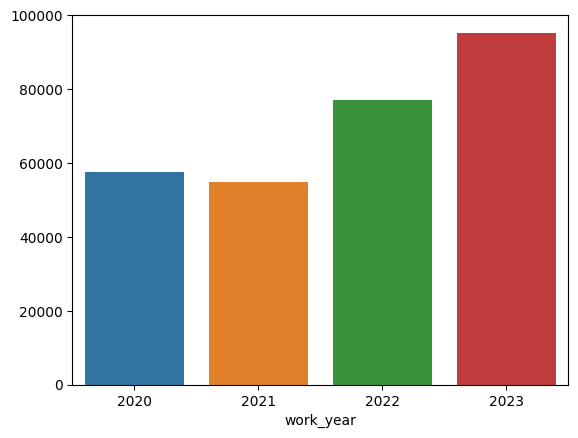

In [296]:
sns.barplot(x = year.index, y = year.values);
plt.xticks();

El gráfico nos muestra que los salarios en data science, para el grupo de personas con el menor nivel de experiencia ha incrementado considerablemente en los años 2022 y 2023.

<ipython-input-228-25d31c46efb3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

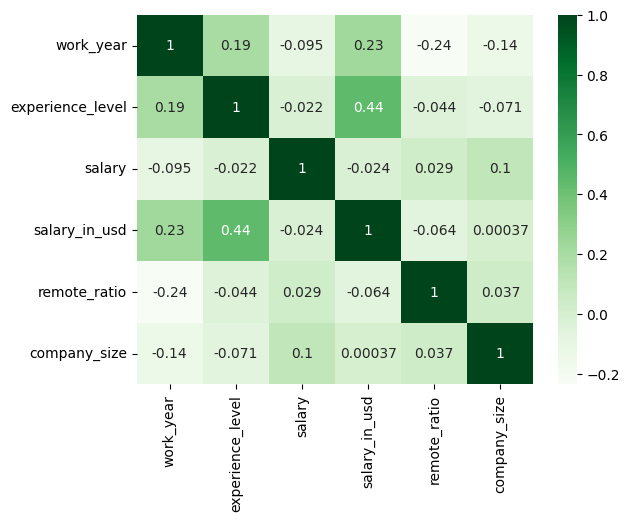

In [228]:
# Se agrega un mapa de calor, para hallar las correlaciones entre variables
corr = df.corr()
sns.heatmap(corr, cmap = 'Greens', annot = True)

La mejor correlación se da entre las variables "salary_in_usd" y "experience_level". No se han identificado otras relaciones entre variables, que tengan un nivel moderado de significancia.

In [229]:
# "salary_in_usd" es el objetivo y el resto de las variables conforman la matriz de características
# Se eliminan las variables "salary"	y "salary_currency"
X = df.drop(columns=['salary_in_usd', 'salary', 'salary_currency', 'work_year'])
y = df['salary_in_usd']
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [230]:
# instanciar los selectores a nuestros tipos de datos numéricos y categóricos
num_selector = make_column_selector(dtype_include='number')
cat_selector = make_column_selector(dtype_include='object')

In [231]:
# Instanciar transformadores
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [232]:
# Instanciar pipelines
# Numérico
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [233]:
# Categórico
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [234]:
# Instanciar
# Tuplas para columntransformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8104186980>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8104184e50>)])

In [235]:
# Ajustar a datos 'train'
preprocessor.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8104186980>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f8104184e50>)])

In [236]:
# Transformar datos 'train' y 'test'
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [237]:
# Comprobar los valores faltantes y que los datos se escalen y tengan una codificación one-hot
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (2816, 228)




array([[-0.95776217,  1.08444468, -2.76695967, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.52251131, -0.97198375, -0.21980098, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.52251131,  1.08444468, -0.21980098, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 2.00278479,  1.08444468, -0.21980098, ...,  0.        ,
         1.        ,  0.        ],
       [-0.95776217,  0.05623047, -0.21980098, ...,  0.        ,
         0.        ,  0.        ],
       [-0.95776217,  1.08444468, -0.21980098, ...,  0.        ,
         0.        ,  0.        ]])

**Modelo de regresión lineal para la predicción de salario**

In [238]:
# Importar el modelo
from sklearn.linear_model import LinearRegression

In [239]:
# Instanciar el modelo
reg = LinearRegression()

In [240]:
# Encajar modelo para que aprenda relación entre "x" e "y"
reg.fit(X_train_processed,y_train)

LinearRegression()

Evaluar el rendimiento del modelo

In [241]:
# Obtener los datos de R^2 después de ajustar nuestro modelo
train_score = reg.score(X_train_processed, y_train)
print(train_score)

0.4906349983620336


In [242]:
test_score = reg.score(X_test_processed, y_test)
print(test_score)

-4.740088165012153e+19


In [243]:
# Obtener las predicciones del conjunto de entrenamiento
train_preds = reg.predict(X_train_processed)
# Obtener las predicciones del conjunto de prueba
test_preds = reg.predict(X_test_processed)

El modelo de regresión lineal no es apropiado para este caso, es algo que ya se evidenciaba desde el momento en que se realizó el mapa de correlación.

**Modelo de árbol de regresión para la predicción de salario**

In [244]:
# Importar librerias
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

In [245]:
# Hacer una instancia del modelo
# Al dejar los paréntesis vacíos, estamos eligiendo utilizar todos los parámetros por defecto
dec_tree = DecisionTreeRegressor(random_state = 42)

In [246]:
# Ajustar el modelo usando los datos de entrenamiento
dec_tree.fit(X_train_processed, y_train)

DecisionTreeRegressor(random_state=42)

In [247]:
# Predecir los valores objetivos para el conjunto de entrenamiento y de prueba
train_preds = dec_tree.predict(X_train_processed)
test_preds = dec_tree.predict(X_test_processed)

In [248]:
# Evaluar el modelo
train_score = dec_tree.score(X_train_processed, y_train)
test_score = dec_tree.score(X_test_processed, y_test)
print(train_score)
print(test_score)

0.5809302970546355
0.3237278745984721


In [249]:
import numpy as np
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [250]:
# Coeficiente de determinación (r^2)
r2_train = r2_score(y_train, train_preds)
r2_test = r2_score(y_test, test_preds)

In [251]:
r2_train

0.5809302970546355

In [252]:
r2_test

0.3237278745984721

In [253]:
# Raíz del error cuadrático medio (RECM)
rmse_train = np.sqrt(mean_squared_error(y_train, train_preds))
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))

In [254]:
rmse_train

40592.71329536504

In [255]:
rmse_test

52675.43198562461

Modelo de bosques aleatorios para la predicción del salario

In [256]:
# Importar un regresor de bosque aleatorio
from sklearn.ensemble import RandomForestRegressor

In [257]:
# Hacer una instancia del modelo
rf = RandomForestRegressor(random_state = 42)

In [258]:
# Observar algunos hiperparametros
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [259]:
# Entrenar modelo
rf.fit(X_train_processed, y_train)

RandomForestRegressor(random_state=42)

In [260]:
# Predecir valores para "y"
rf.predict(X_test_processed)

array([206520.60166667, 118647.6130864 , 167190.51141052, 203256.99923898,
        91587.905     ,  32347.78      , 164680.22074033,  57928.00017931,
        14763.495     , 172888.22171995,  52914.99583333, 157555.65966806,
       154792.21299158,  16210.717     , 128468.71926346, 127119.14885714,
       121623.09100591, 167190.51141052, 157555.65966806, 164680.22074033,
       131566.08604845, 118647.6130864 , 157555.65966806, 126611.06866667,
       164680.22074033, 122609.3448001 , 191766.39322072, 118647.6130864 ,
        94906.389     , 137375.04226173, 172794.39222549, 118647.6130864 ,
       156685.87222222, 112569.75449856,  56700.40001587, 148509.00724276,
        16369.44      ,  32911.93      , 128468.71926346, 154792.21299158,
       171791.66583861,  27582.05933333, 134810.44066437, 129028.24922222,
       163497.04565312, 128468.71926346, 138085.49712698, 154792.21299158,
        95413.02414566, 132481.115     ,  16587.30125   ,  91347.60633836,
       164680.22074033, 1

In [261]:
# Evaluar el rendimiento del modelo
rf_train_score = rf.score(X_train_processed, y_train)
rf_test_score = rf.score(X_test_processed, y_test)
print(rf_train_score)
print(rf_test_score)

0.5664974610018964
0.3763219865066767


In [262]:
# Establecer max_depth a 9 y evaluar nuestros resultados
rf_9 = RandomForestRegressor(max_depth = 9, random_state = 42)
rf_9.fit(X_train_processed, y_train)
rf_9_train_score = rf_9.score(X_train_processed, y_train)
rf_9_test_score = rf_9.score(X_test_processed, y_test)
print(rf_9_train_score)
print(rf_9_test_score)

0.5113259136534594
0.3723654991537174


In [263]:
# Ver cuál era la profundidad de cada árbol en el bosque aleatorio cuando el max_depth era ilimitado
[estimator.get_depth() for estimator in rf.estimators_]

[40,
 38,
 46,
 37,
 42,
 43,
 38,
 37,
 41,
 42,
 42,
 36,
 43,
 43,
 41,
 40,
 39,
 40,
 39,
 38,
 43,
 35,
 45,
 40,
 43,
 45,
 39,
 39,
 41,
 44,
 42,
 45,
 41,
 45,
 40,
 41,
 46,
 42,
 44,
 40,
 39,
 41,
 41,
 40,
 36,
 44,
 42,
 45,
 42,
 39,
 46,
 44,
 40,
 42,
 40,
 42,
 36,
 42,
 44,
 40,
 46,
 46,
 45,
 43,
 38,
 46,
 41,
 42,
 42,
 48,
 39,
 41,
 44,
 42,
 37,
 40,
 40,
 42,
 43,
 41,
 48,
 44,
 40,
 45,
 42,
 39,
 40,
 43,
 43,
 39,
 42,
 42,
 39,
 48,
 40,
 43,
 41,
 44,
 42,
 40]

In [264]:
# Afinar n_estimators
# Intentar 200 árboles
rf_200 = RandomForestRegressor(n_estimators = 200, random_state = 42)
# Ajustar el modelo
rf_200.fit(X_train_processed, y_train)
# Obtener las puntuaciones
rf_200_train_score = rf_200.score(X_train_processed, y_train)
rf_200_test_score = rf_200.score(X_test_processed, y_test)
print(rf_200_train_score)
print(rf_200_test_score)

0.5667713980245802
0.37836275441487155


Modelo KNN para predicción del salario

In [266]:
# Importar biblioteca
from sklearn.neighbors import KNeighborsClassifier

In [267]:
# hacer una instancia del modelo
knn = KNeighborsClassifier(n_neighbors=1)

In [268]:
# Observar hiperparámetros
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [269]:
# Poner scaler y el modelo en un pipeline y ajustar el pipeline en los datos de entrenamiento
knn_pipe = make_pipeline(scaler, knn)
knn_pipe.fit(X_train_processed, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

In [271]:
# Predecir los valores para el conjunto de prueba
predictions = knn_pipe.predict(X_test_processed)
predictions

array([183600, 127000, 136000, 350000,  85000, 157000, 140000,  55000,
        12767, 145000,  52533, 188700, 172200,  17022,  95000, 138000,
       160000, 136000, 188700, 140000,  90000, 127000, 188700, 135000,
       140000, 160000, 170000, 127000, 174000, 102100, 150000, 127000,
       144000, 130000,  51321, 155000,  12767,  50000,  95000, 172200,
       200000, 220000,  69751, 109024, 154600,  95000, 180000, 172200,
       120000, 101943,  16414, 200000, 140000, 127000, 140000, 154600,
       100000, 140000, 136000, 127467, 172200, 120000,  50432, 140000,
       150000,  17022,  90000, 124000, 100000, 140000, 159000, 100000,
       130760,  90000, 148500, 180000, 140000, 128000, 200000, 123000,
        80036, 140000, 172200, 220000, 183000,  64385, 116250, 172200,
       121093, 156400,  97218, 188000, 136000, 120000, 116250, 127000,
       140000,  62000, 220000, 136000, 136000,  94000, 136000, 172200,
        76000, 220000, 185000, 131300, 160000, 140000, 110000, 127000,
      

In [273]:
# Evaluar rendimiento en conjunto de prueba
# Calcular la exactitud de la clasificación
acc_score = knn_pipe.score(X_test_processed, y_test)
acc_score

0.0362087326943557

El modelo con los mejores resultados es el de "bosques aleatorios"

Red neuronal aplicada al problema de regresión

In [275]:
# Importar bibliotecas
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [274]:
# Definir estructura de red
# Grabar el número de características que tenemos para "input"
input_shape = X_train_processed.shape[1]
input_shape

228

In [276]:
# Modelo secuencial
model = Sequential()

In [277]:
# Se aplicarán dos capas
# First hidden layer
model.add(Dense(228, # How many neurons you have in your first hidden layer
                input_dim = input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
# Second hidden layer
model.add(Dense(10, # How many neurons you have in your second hidden layer
                activation = 'relu')) # What activation function are you using?

In [279]:
# Output layer
model.add(Dense(1, activation = 'linear'))

In [287]:
# Compilar modelo
model.compile(loss = 'mse', optimizer = 'adam')

In [288]:
# Ajustar modelo
history = model.fit(X_train_processed, y_train,
                    validation_data = (X_test_processed, y_test), 
                    epochs=10)

Epoch 1/10
88/88 [==============================] - 2s 9ms/step - loss: 22932168704.0000 - val_loss: 22792747008.0000
Epoch 2/10
88/88 [==============================] - 1s 6ms/step - loss: 22910269440.0000 - val_loss: 22748786688.0000
Epoch 3/10
88/88 [==============================] - 0s 5ms/step - loss: 22829733888.0000 - val_loss: 22626017280.0000
Epoch 4/10
88/88 [==============================] - 0s 6ms/step - loss: 22648582144.0000 - val_loss: 22384089088.0000
Epoch 5/10
88/88 [==============================] - 0s 5ms/step - loss: 22330331136.0000 - val_loss: 21989670912.0000
Epoch 6/10
88/88 [==============================] - 1s 6ms/step - loss: 21845547008.0000 - val_loss: 21421893632.0000
Epoch 7/10
88/88 [==============================] - 0s 5ms/step - loss: 21174773760.0000 - val_loss: 20661362688.0000
Epoch 8/10
88/88 [==============================] - 0s 4ms/step - loss: 20308445184.0000 - val_loss: 19710562304.0000
Epoch 9/10
88/88 [==============================] - 0s 4

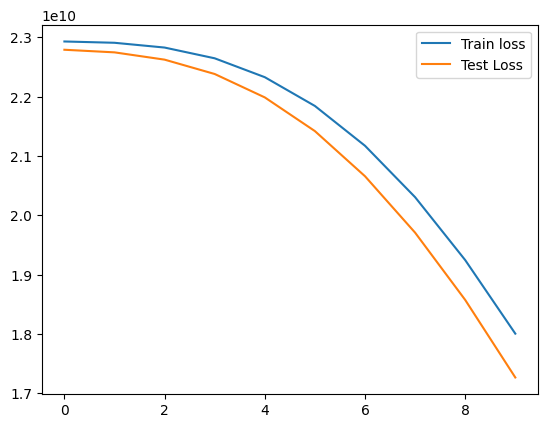

In [289]:
# Visualize the loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend();